This notebook should be executed on a GPU runtime.

In [ ]:
# Download nessecary libraries
!pip install datasets --quiet
!pip install transformers[torch] --quiet
!pip install --upgrade accelerate --quiet
!pip install evaluate --quiet
!pip install jiwer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load the preprocessed dataet
from datasets import DatasetDict

ds = DatasetDict.load_from_disk("./drive/MyDrive/ASR_Colab/dataset.hf")

# Remove unnessecary columns for network traning to save RAM
model_columns = ['input_values', 'input_length', 'labels']
ds['train'] = ds['train'].remove_columns([col for col in ds['train'].column_names if col not in model_columns])
ds['test'] = ds['test'].remove_columns([col for col in ds['test'].column_names if col not in model_columns])

To know what is the role of tokenizer, feature extractor, data collator & etc. in this model, visit https://huggingface.co/blog/fine-tune-xlsr-wav2vec2

In [ ]:
from transformers import Wav2Vec2CTCTokenizer,Wav2Vec2FeatureExtractor,Wav2Vec2Processor

tokenizer = Wav2Vec2CTCTokenizer("./drive/MyDrive/ASR_Colab/vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
# show a row of our processed dataset and how they are encoded
from IPython.display import Audio

example = ds['train'][1]

print(example["labels"])
print(example["input_values"][0:10])

print(tokenizer.decode(example["labels"]))
Audio(example["input_values"], rate=16000)

[17, 3, 42, 13, 3, 14, 16, 0, 3, 13, 14, 7, 13, 42, 51, 0, 40, 13, 14, 7, 13, 49, 12, 41, 16, 13, 20, 51, 43, 13, 16, 21, 42, 40, 11, 13, 32, 40, 21, 12, 0, 13]
[-0.031488243490457535, -0.046497490257024765, -0.046532515436410904, -0.03285027667880058, -0.015328288078308105, -0.004773360677063465, -0.005951134953647852, -0.016155477613210678, -0.028513094410300255, -0.0363040454685688]
خاک ابتدا به کندی به صورت سنگ تشکیل میشود


In [ ]:
import torch
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

# Data collator pads each of the voices and transcripts for them have a same size
# lets see what collator does to some random rows:
example_features = [
    ds["train"][0],
    ds["train"][1],
    ds["train"][20],
]
example_batch = data_collator(example_features)
{k:v.shape for k,v in example_batch.items()}

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


{'input_values': torch.Size([3, 94592]),
 'attention_mask': torch.Size([3, 94592]),
 'labels': torch.Size([3, 71])}

In [ ]:
# feel free to adjust these parameters if training doesn't converge
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=processor.tokenizer.vocab_size
)
model.freeze_feature_encoder()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Change the following parameters if you deem nessecary, specially if you run out of GPU RAM or don't reach the desired performance
from transformers import TrainingArguments

save_dir = 'wav2vec_cache'
training_args = TrainingArguments(
    output_dir=save_dir,
    logging_dir='./logs',
    group_by_length=False,
    per_device_train_batch_size=1,  # using small batch size to prevent GPU running out of memory
    gradient_accumulation_steps=10, # using mini-batches to prevent GPU running out of memory
    evaluation_strategy="steps",
    num_train_epochs=3,             # increasing number of epochs can increase model performance, but takes longer time to train
    fp16=True,
    save_steps=200,
    eval_steps=100,
    logging_steps=50,
    learning_rate=4e-4,
    warmup_steps=200,
    save_total_limit=1,
    load_best_model_at_end = True
)

In [ ]:
# Load wer(Word Error Rate) metric
import evaluate

wer_metric = evaluate.load("wer")
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1404, training_loss=2.043382573331523, metrics={'train_runtime': 6071.9277, 'train_samples_per_second': 2.312, 'train_steps_per_second': 0.231, 'total_flos': 2.574153695628679e+18, 'train_loss': 2.043382573331523, 'epoch': 3.0})

In [ ]:
# save model weights for the evaluation step
trainer.save_model("./drive/MyDrive/ASR_Colab/model_weights")

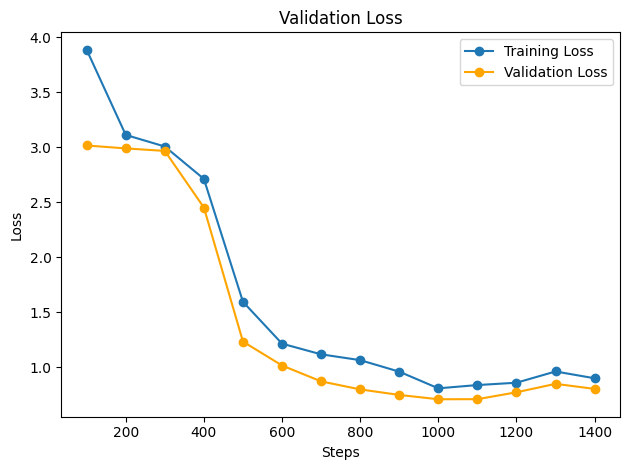

In [ ]:
import json
import matplotlib.pyplot as plt

# Load metrics
with open('./logs/trainer_state.json', 'r') as f:
    metrics = json.load(f)

# Extract metrics
training_loss = metrics['log_history']
validation_loss = [entry['eval_loss'] for entry in metrics['log_history'] if 'eval_loss' in entry]
wer = [entry['eval_wer'] for entry in metrics['log_history'] if 'eval_wer' in entry]
steps = range(100,1500,100)

# Training Loss
plt.plot(steps,training_loss, '-o', label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Validation Loss
plt.plot(steps, validation_loss, '-o', label='Validation Loss', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

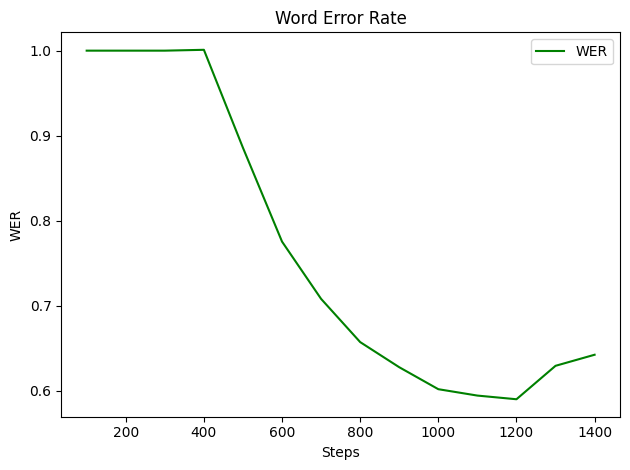

In [ ]:
plt.plot(steps, wer, label='WER', color='green')
plt.xlabel('Steps')
plt.ylabel('WER')
plt.title('Word Error Rate')
plt.legend()

plt.tight_layout()
plt.show()